<img src="https://drive.google.com/uc?id=1o-ZlTxgMPd5I5yHN4kcG12OowVmh6iZF" style="width: 100%;" />


<img src="https://drive.google.com/uc?id=14VDENw3h3x9js4ZNf0Ua5vBMqKe4D1IJ" style="width: 100%;" />


# ID5059 - Individual assignment

# Table of Contents

- Introduction  
- I. Data Exploration  
   - A. Plot 1: Proportion of Disruption (Year, Month, Day, Month)  
   - B. Plot 2: Proportion of Disruption per Airline and by Partner  
   - C. Plot 3: Map of Disruption per State  
   - D. Plot 4: Disruption for States, Cities, and Airports  
   - E. Plot 5: Proportion of Disrupted Flight Over Time  
   - F. Plot 6: Arrival Time, Departure Time, Length of Flight, and Distance Travelled  
   - G. Plot 7: Densities of Distance and Elapsed Time  

- II. Feature Selection  

- III. Data Wrangling  
   - A. Specify Features  
   - B. Preprocessing Logic for Distance  
   - C. Preprocessing Logic for City Names  
   - D. Preprocessing Logic for Airline  
   - E. Preprocessing Logic for Time Block  
   - F. Preprocessing Logic for Arrival Time  
   - G. Preprocessing Logic for is_covid  
   - H. Define the Full Pipeline  
   - I. Get_feature_names Function  
   - K. Create Wrapper Functions for the Full Fit and Transform Logic  
   - L. Transformed Data  

- IV. Strategy and Split the Data  

- V. Model 1: Random Forest  
   - A. Tuning  
   - B. Training and Preliminary Evaluation  

- VI. Model 2: XGBOOST  
   - A. Tuning  
   - B. Training and Preliminary Evaluation  

- VII. Model 3: Neural Network  
   - A. Tuning  
   - B. Training and Preliminary Evaluation  

- VIII. Choose the Best Model  

- IX. Tune on the Full Training Set  

- X. Evaluate on the Test Set  
   - A. Metrics
   - B. Confusion Matrix
   - C. ROC
   - D. Precision and recall   
   - E. Threshold
   
- Conclusion


# Introduction

This project analyzed data on disrupted flights, taking into account factors like time, airlines, and locations. It used data preprocessing techniques and created three predictive models: Random Forest, XGBOOST, and Neural Network. The Neural Network model outperformed the others. Analysis showed that time factors and the COVID-19 pandemic had a significant impact on flight disruptions. The project proposes various preprocessing strategies for significant categorical features. It also presents a neural network implementation to predict flight disruptions, along with a detailed error analysis. Finally, the project is put in the context of a business question to determine the most suitable solution.

# Notebook setup

In [10]:
# Dependencies
# !pip install plotly
# !pip install tensorflow

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from itertools import product
from IPython.display import HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [8]:
# Link google drive
from google.colab import drive
drive.mount('/content/drive')

# Import Data
Airline_train_link = '/content/drive/My Drive/Airline_train.csv'
Airline_train = pd.read_csv(Airline_train_link, delimiter=',', encoding='utf-8')

Airline_test_link = '/content/drive/My Drive/Airline_test.csv'
Airline_test = pd.read_csv(Airline_test_link, delimiter=',', encoding='utf-8')

Mounted at /content/drive


# I) Data exploration
### A) Plot data types, null values

In [39]:
# Show information on null values and data types
null_info = pd.DataFrame({ 'Variable': Airline_train.columns, 'Null Values': Airline_train.isnull().sum(), 'Data Type': Airline_train.dtypes})

print(null_info.to_string(index=False))

                               Variable  Null Values Data Type
                             FlightDate            0    object
                                Airline            0    object
                                 Origin            0    object
                                   Dest            0    object
                             CRSDepTime            0     int64
                         CRSElapsedTime            1   float64
                               Distance            0     int64
                                   Year            0     int64
                                Quarter            0     int64
                                  Month            0     int64
                             DayofMonth            0     int64
                              DayOfWeek            0     int64
              Marketing_Airline_Network            0    object
Operated_or_Branded_Code_Share_Partners            0    object
               DOT_ID_Marketing_Airline            0   

### B) Plot 1: Proportion of disruption (Year, month, day, month)


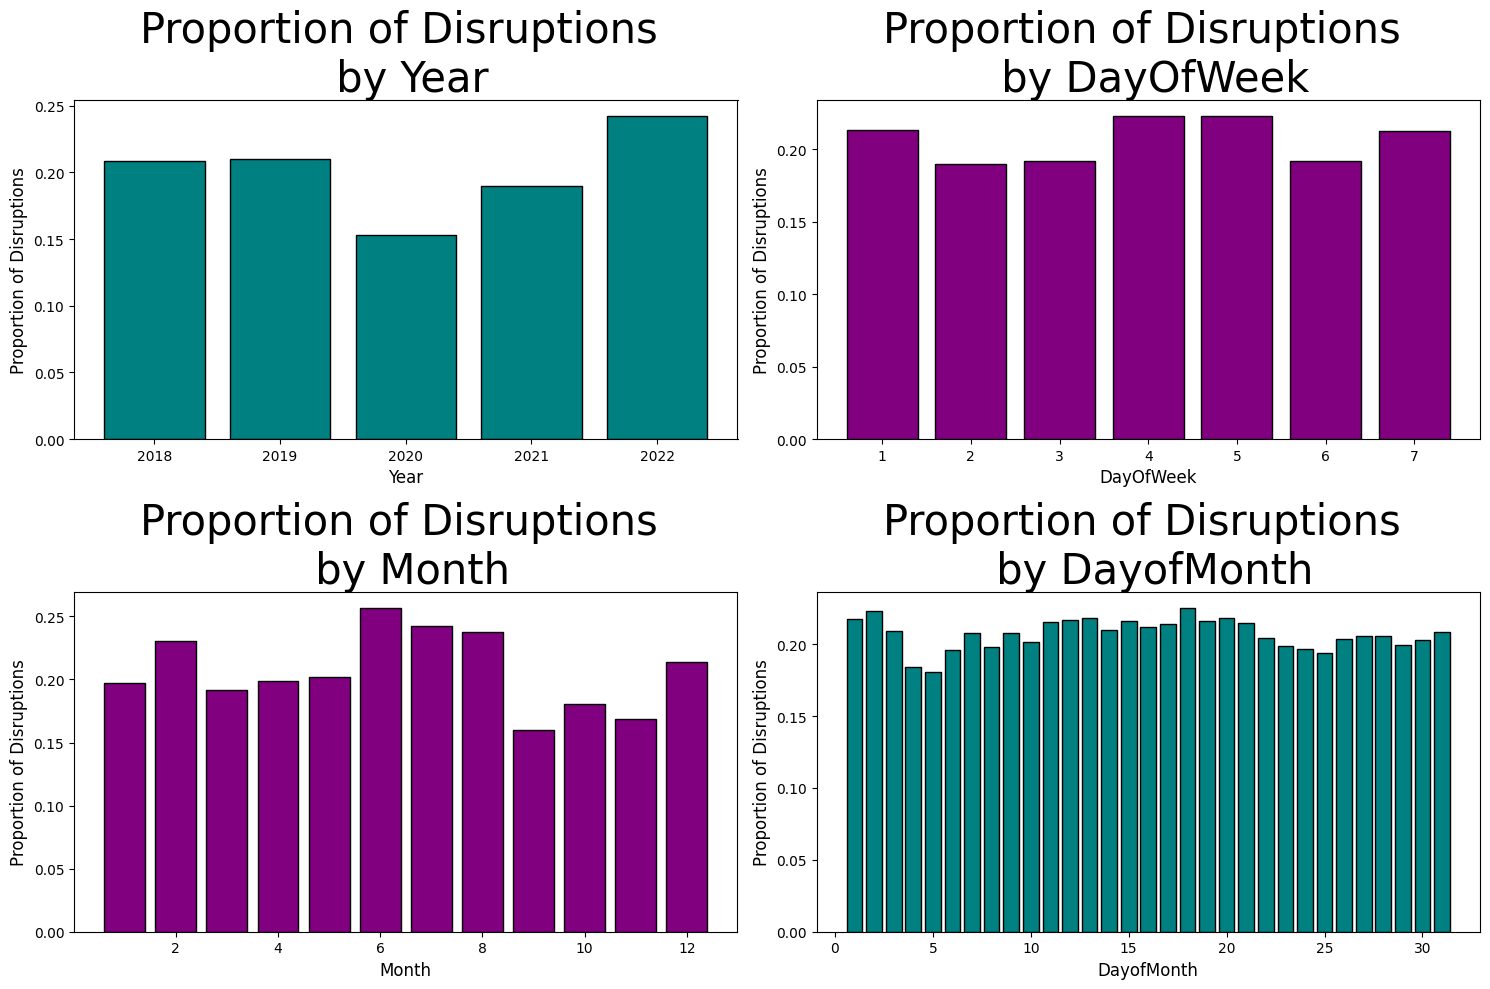

In [ ]:
def plot_proportion_histograms(dataframe):
    # Define variables
    vars = ['Year', 'DayOfWeek', 'Month', 'DayofMonth']
    bin = [20, 7, 12, 31]
    col = ['teal', 'purple', 'purple', 'teal']

    # Create grid plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.ravel()

    # Loop through the variables to generate histograms
    for i, var in enumerate(vars):
        # Group by variable
        grouped = dataframe.groupby(var)['Disruption'].mean()

        # Create histograms
        axs[i].bar(grouped.index, grouped, color=col[i], edgecolor='black')
        axs[i].set_title(f'Proportion of Disruptions \n by {var}', fontsize=30)
        axs[i].set_xlabel(var, fontsize=12)
        axs[i].set_ylabel('Proportion of Disruptions', fontsize=12)

    plt.tight_layout()

    plt.show()

plot_proportion_histograms(Airline_train)

<u>Takeaways</u>: these observations bring us to decide to include the month and day of the week as covariates and to include a variable is_covid to control for the effect of the pandemic on the proportion of disrupted flights.


### C) Plot 2: Proportion of disruption per Airline and by Partner

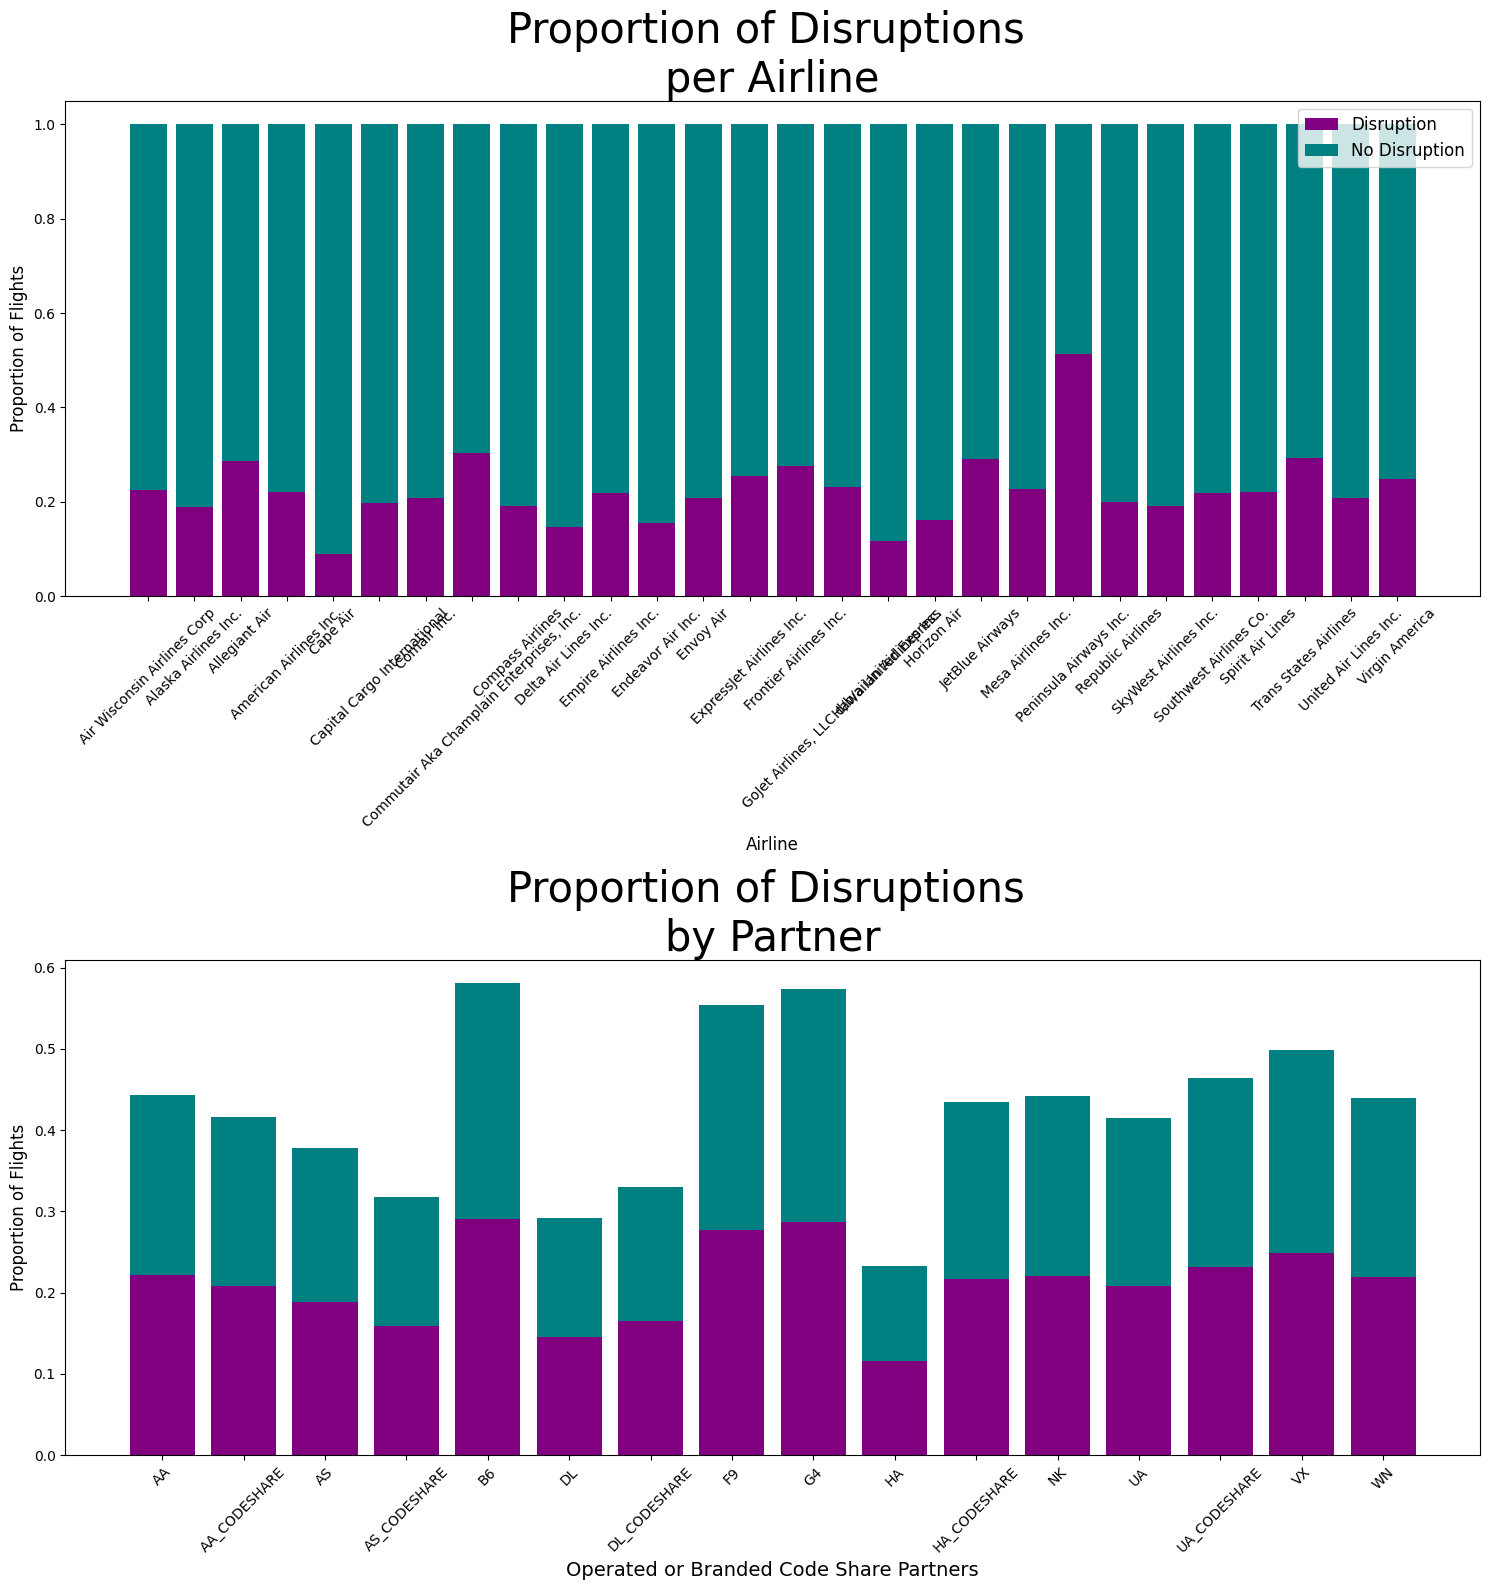

In [ ]:
group_air = Airline_train.groupby(['Airline', 'Disruption']).size().unstack(fill_value=0)
group_air = group_air.div(group_air.sum(axis=1), axis=0)

# For partners
t_flights = Airline_train.groupby('Operated_or_Branded_Code_Share_Partners').size()
d_p = Airline_train[Airline_train['Disruption'] == 1].groupby('Operated_or_Branded_Code_Share_Partners').size()
nod_p_n = Airline_train[Airline_train['Disruption'] == 0].groupby('Operated_or_Branded_Code_Share_Partners').size()
proportions_1 = d_p / t_flights
proportions_2 = nod_p_n / t_flights
proportions_1 = proportions_1.reindex(t_flights.index, fill_value=0)
proportions_2 = proportions_2.reindex(t_flights.index, fill_value=0)

# Set up grid
fig, axs = plt.subplots(2, 1, figsize=(15, 16))

# Plot for airlines
axs[0].bar(group_air.index, group_air[1], color='purple')
axs[0].bar(group_air.index, group_air[0], bottom=group_air[1], color='teal')
axs[0].set_title('Proportion of Disruptions \nper Airline', fontsize=30)
axs[0].set_xlabel('Airline', fontsize=12)
axs[0].set_ylabel('Proportion of Flights', fontsize=12)
axs[0].legend(['Disruption', 'No Disruption'], fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# Plot for partners
axs[1].bar(proportions_1.index, proportions_1.values, color='purple')
axs[1].bar(proportions_1.index, proportions_1.values, bottom=proportions_1.values, color='teal')
axs[1].set_title('Proportion of Disruptions \nby Partner', fontsize=30)
axs[1].set_xlabel('Operated or Branded Code Share Partners', fontsize=14)
axs[1].set_ylabel('Proportion of Flights', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



<u>Takeaways</u>: We can see that both the airline and the partners have an effect on the proportion of disrupted flights.
Later, however, we will see that both of these categorical variables are correlated, which brings us to choose only one as a covariate.

### D) Plot 3: Map of disruption per state

In [ ]:
# Drop Space spaces from state abbreviations
Airline_train['OriginState'] = Airline_train['OriginState'].str.strip()

# Group by state, compute the mean
prop = Airline_train.groupby('OriginState')['Disruption'].mean().reset_index()
prop.columns = ['State', 'Disruption']

# define colours
custom_color_scale = [
    (0.00, "teal"),
    (1.00, "purple")]

fig = px.choropleth(
    prop,
    locations='State',
    locationmode='USA-states',
    color='Disruption',
    scope="usa",
    color_continuous_scale=custom_color_scale,
    labels={'Disruption': 'Proportion of Disruptions'})

# set grid
fig.update_layout(
    title_text='Proportion of Disrupted Flights by State in the USA',
    title_font_size=30)

fig.show()


<u>Takeaways</u>: We can see from the map that there is no major variation in the proportion of disruption per state. we therefore decide not to include states as a covariate in our analysis.


### E) Plot 4: Diruption for states, cities and airpots

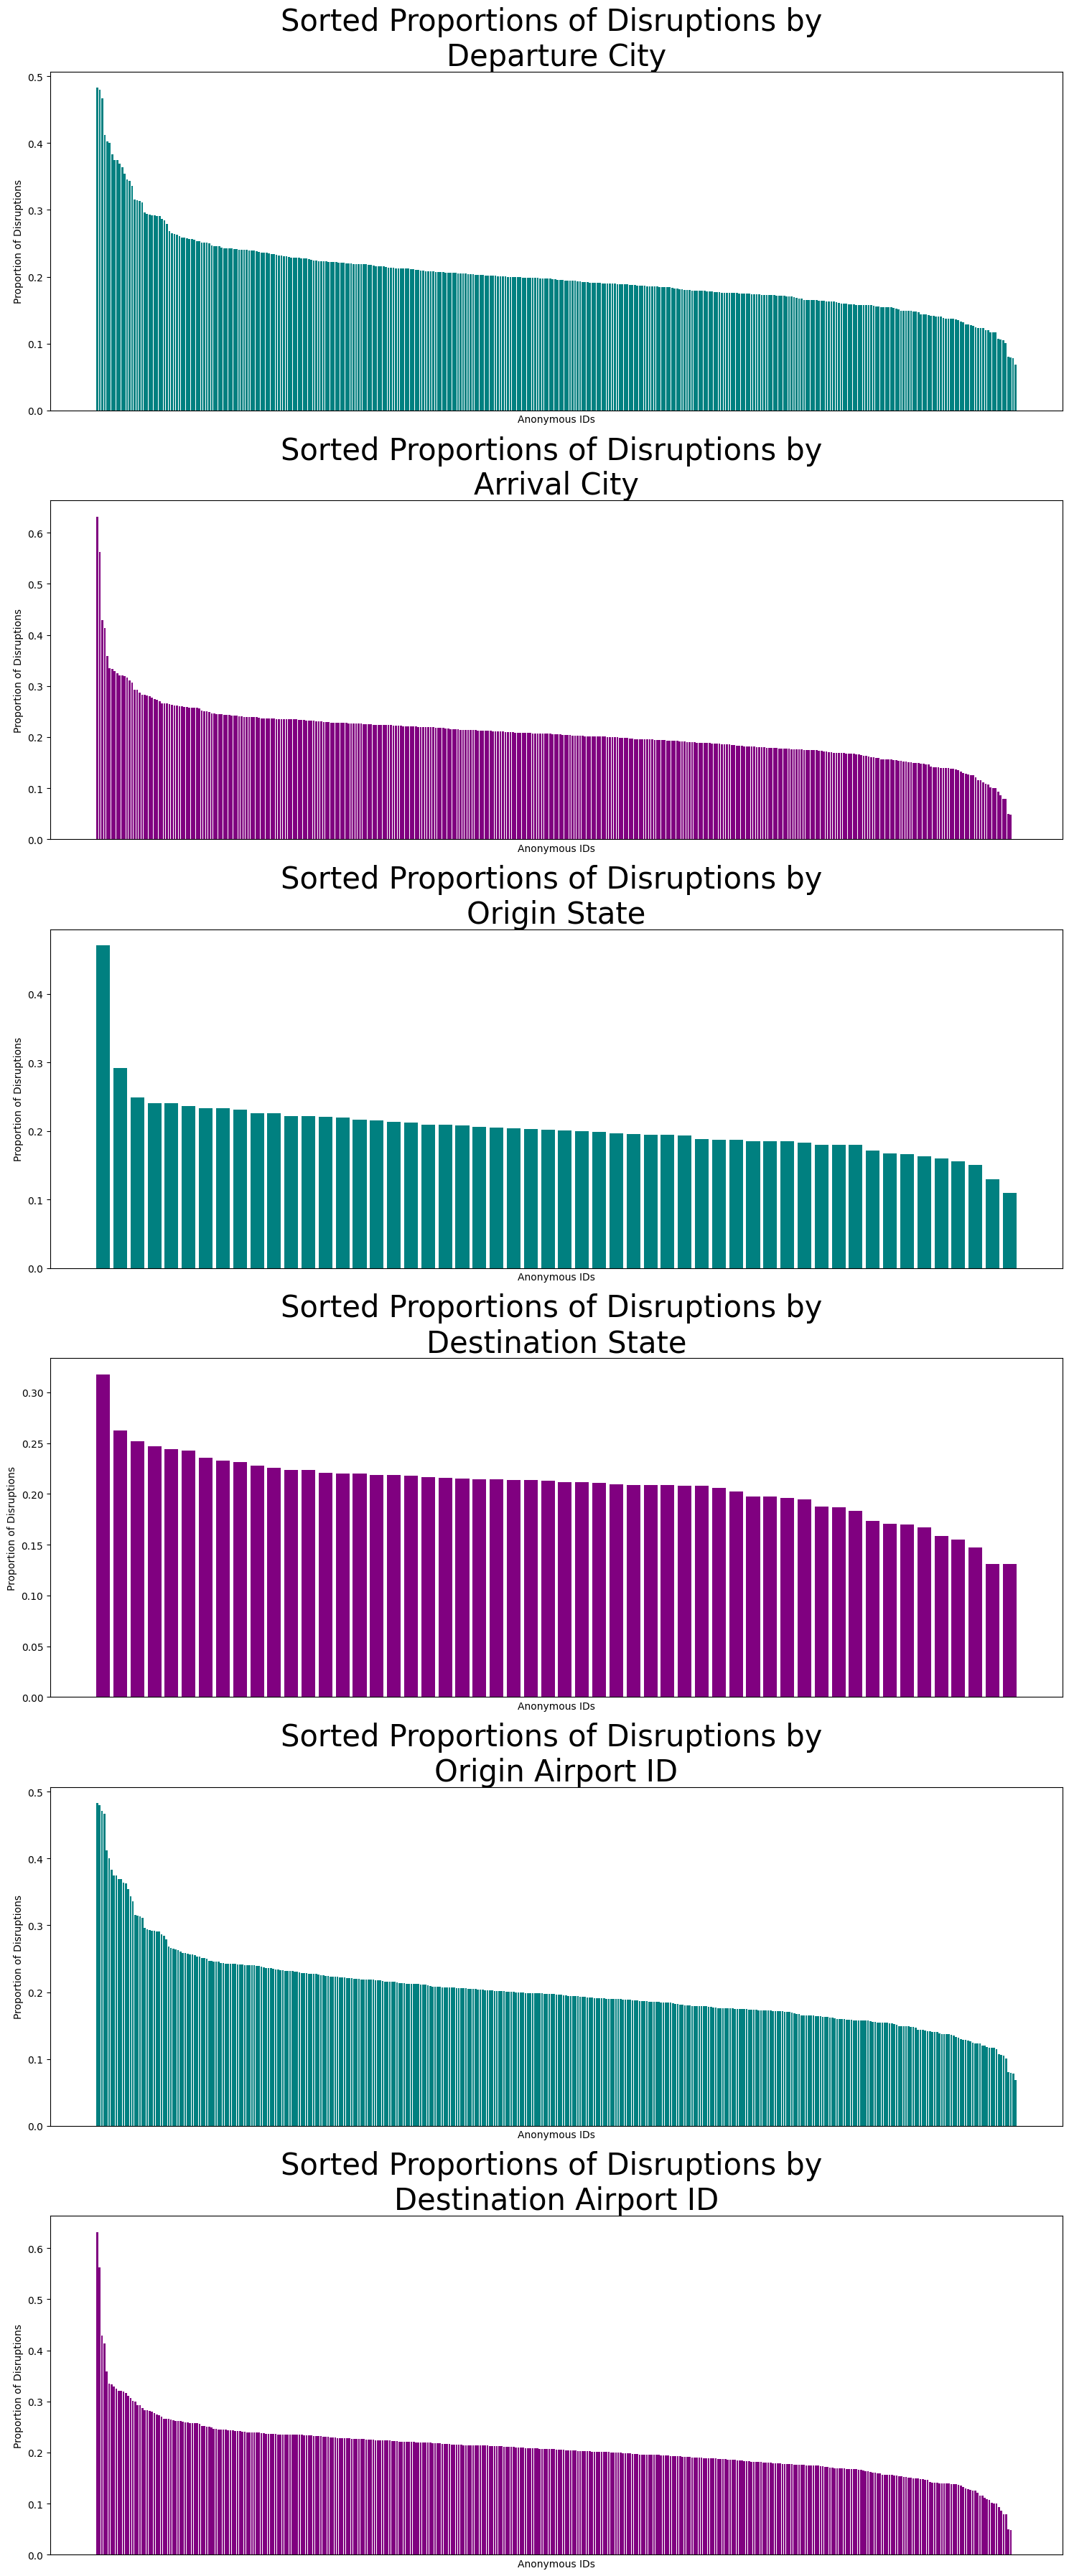

In [ ]:
def disruption_prop(data, title, color, ax):
    srted = data.sort_values(by='Disruption', ascending=False)
    ax.bar(range(len(srted)), srted['Disruption'], color=color)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel('Anonymous IDs')
    ax.set_ylabel('Proportion of Disruptions')
    ax.set_xticks([])

# Group by data for each category
d_c_proportions = Airline_train.groupby('OriginCityName')['Disruption'].mean().reset_index()
a_c_proportions = Airline_train.groupby('DestCityName')['Disruption'].mean().reset_index()
o_s_proportions = Airline_train.groupby('OriginState')['Disruption'].mean().reset_index()
s_s_proportions = Airline_train.groupby('DestState')['Disruption'].mean().reset_index()
o_a_proportions = Airline_train.groupby('OriginAirportID')['Disruption'].mean().reset_index()
d_s_proportions = Airline_train.groupby('DestAirportID')['Disruption'].mean().reset_index()

# Set grid
fig, axs = plt.subplots(6, 1, figsize=(15, 36))

# Plot
disruption_prop(d_c_proportions, 'Sorted Proportions of Disruptions by \nDeparture City', 'teal', axs[0])
disruption_prop(a_c_proportions, 'Sorted Proportions of Disruptions by \nArrival City', 'purple', axs[1])
disruption_prop(o_s_proportions, 'Sorted Proportions of Disruptions by \nOrigin State', 'teal', axs[2])
disruption_prop(s_s_proportions, 'Sorted Proportions of Disruptions by \nDestination State', 'purple', axs[3])
disruption_prop(o_a_proportions, 'Sorted Proportions of Disruptions by \nOrigin Airport ID', 'teal', axs[4])
disruption_prop(d_s_proportions, 'Sorted Proportions of Disruptions by \nDestination Airport ID', 'purple', axs[5])

plt.tight_layout()
plt.show()

<u>Takeaways</u>: We can see from these plots that the state, city, and airport don't have a lot of effect on the proportion of disruption. A notable observation is that some departure cities and departure airports seem to have a clear pronounced peak above 0.25. Both of them, however, are correlated as we will see in the mutual information grid. We therefore decide to keep departure airport as a covariate and label it to identify the airports that clearly show more disruption. More information will be included in the preprocessing steps of this notebook.


### F) Plot 5: Plot the proportion of dirupted flight over time.


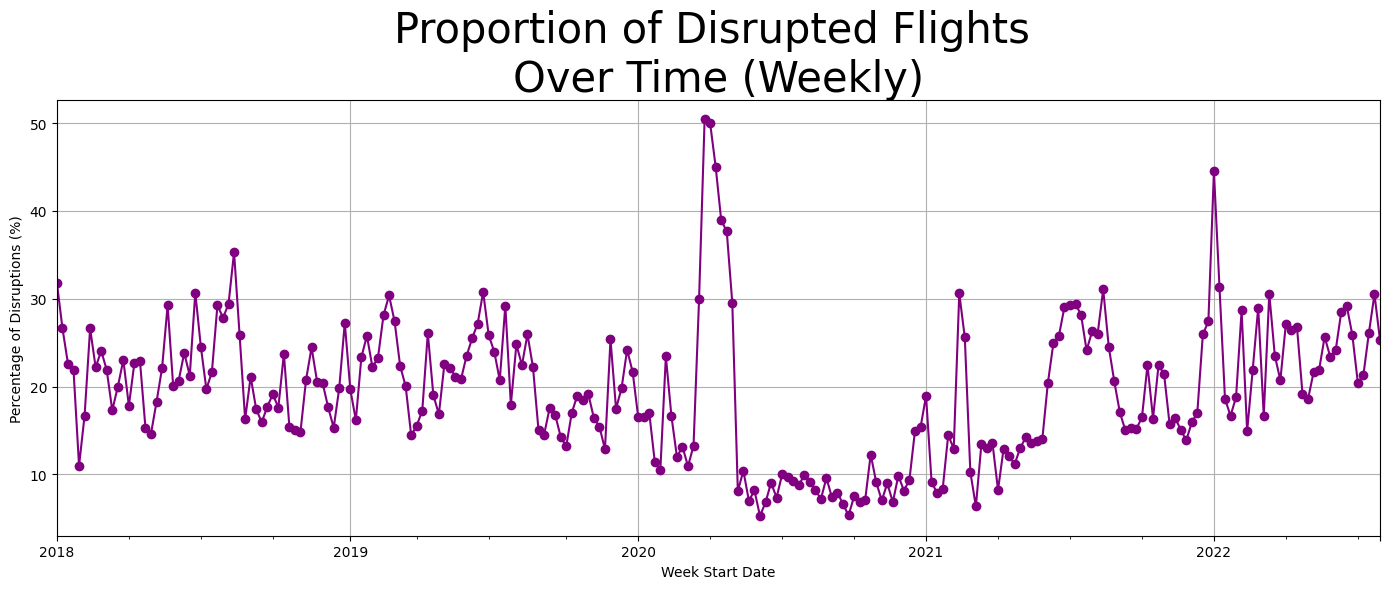

In [ ]:
Airline_train['FlightDate'] = pd.to_datetime(Airline_train['FlightDate'])

# Group by flightdate
w_disruption = Airline_train.resample('W-Mon', on='FlightDate')['Disruption'].mean() * 100

# Plotting the time series
plt.figure(figsize=(14, 6))
w_disruption.plot(kind='line', marker='o', color='purple')
plt.title('Proportion of Disrupted Flights \nOver Time (Weekly)', fontsize=30)
plt.ylabel('Percentage of Disruptions (%)')
plt.xlabel('Week Start Date')
plt.grid(True)
plt.tight_layout()
plt.show()


<u>Takeaways</u>: In this plot, we can see that there seems to be some seasonal variation in the proportion of disrupted flights. This variation seems to be monthly, hence our choice to include month as a covariate. A notable peak, however, in COVID informs us of when the biggest shift in disruption proportions happens, helping us inform what timeline we should use for our is_covid variable.


### G) Plot 6: arival time, departure time, lengh of flight and distance travelled

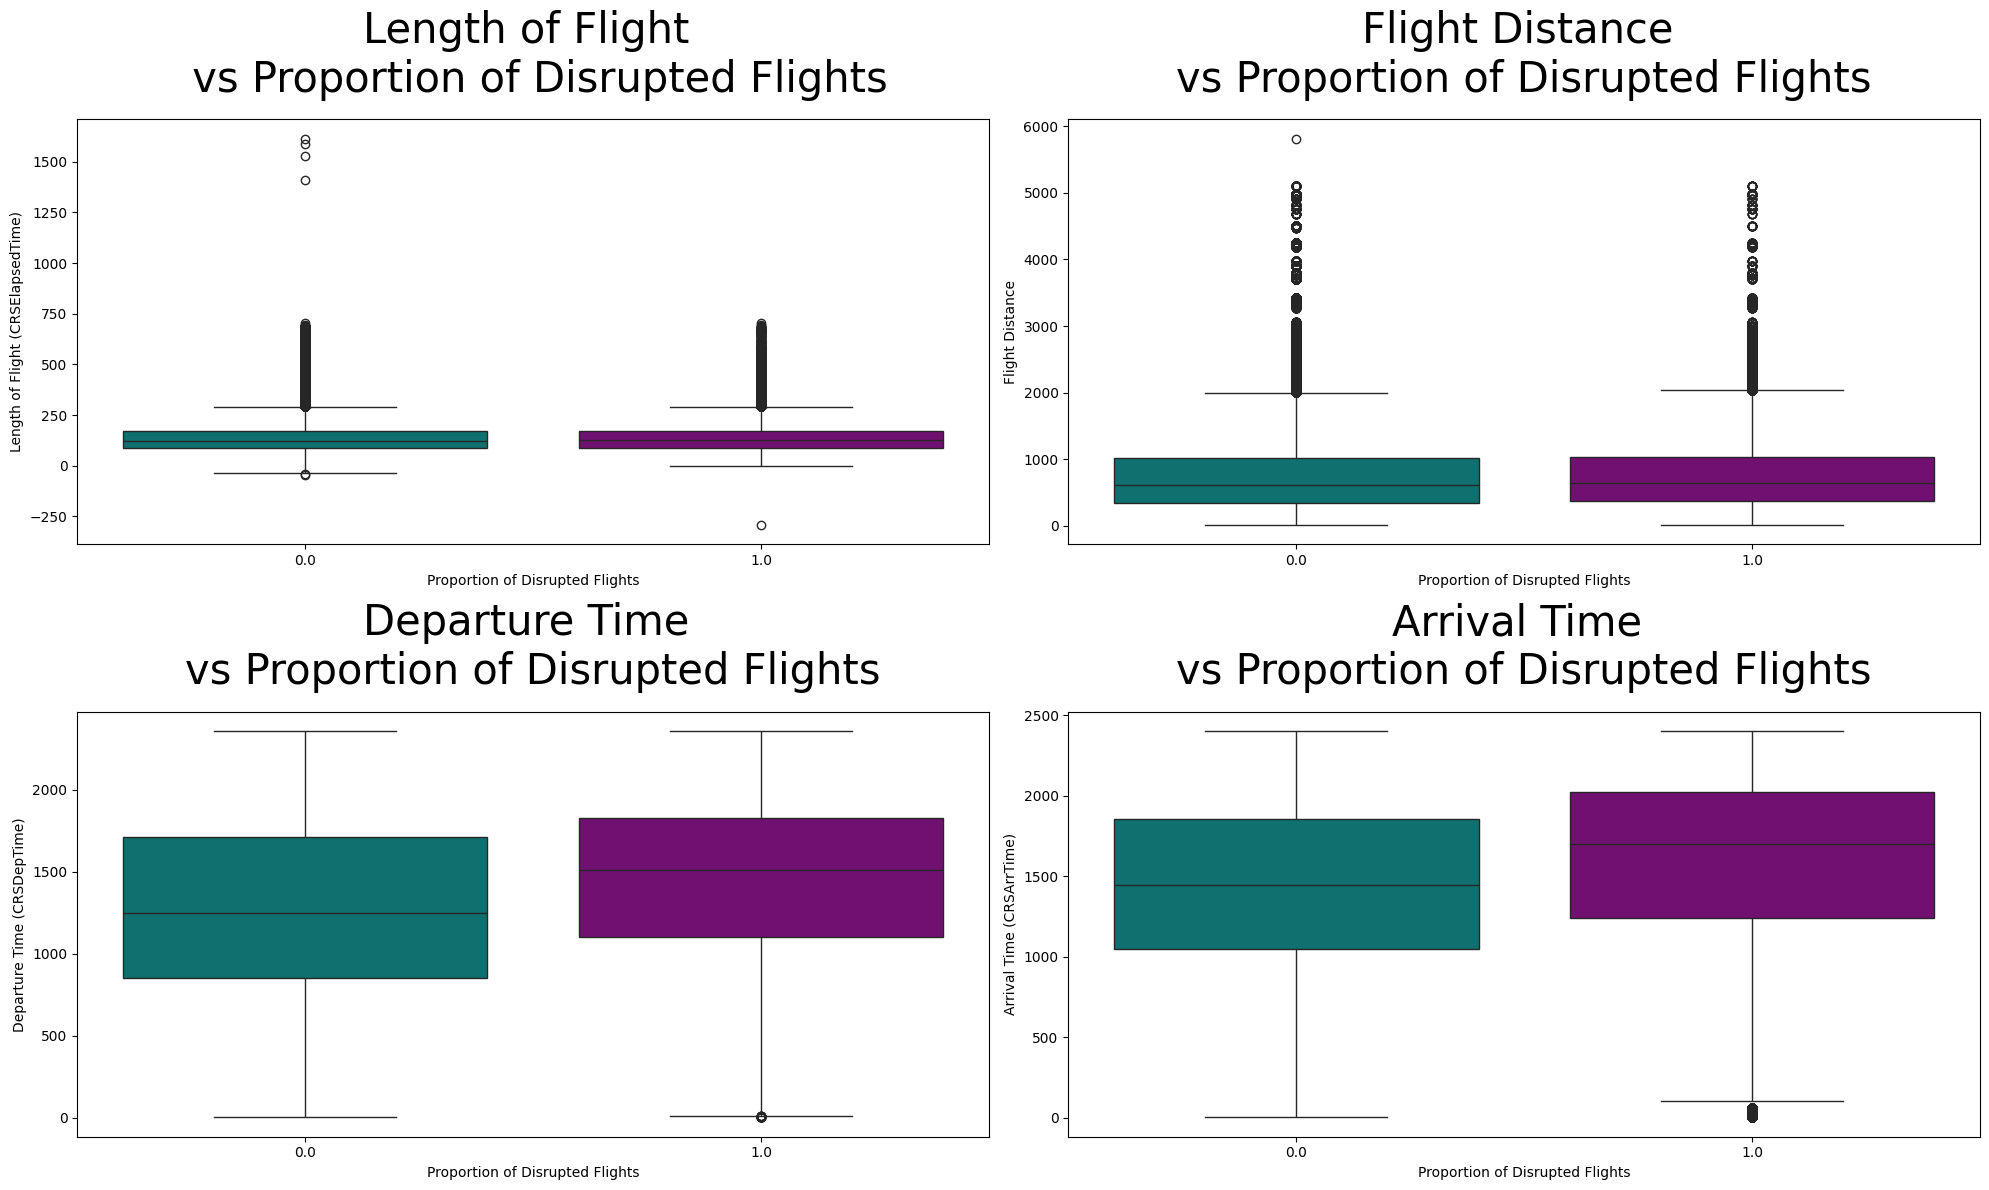

In [ ]:
def l_vs_d(dataframe, ax):
    sns.boxplot(x='Disruption', y='CRSElapsedTime', data=dataframe, hue='Disruption', palette=['teal', 'purple'], legend=False, ax=ax)
    ax.set_title('Length of Flight \n vs Proportion of Disrupted Flights', fontsize=30, pad=20, loc='center')
    ax.set_xlabel('Proportion of Disrupted Flights')
    ax.set_ylabel('Length of Flight (CRSElapsedTime)')

def d_vs_d(dataframe, ax):
    sns.boxplot(x='Disruption', y='Distance', data=dataframe, hue='Disruption', palette=['teal', 'purple'], legend=False, ax=ax)
    ax.set_title('Flight Distance \nvs Proportion of Disrupted Flights', fontsize=30, pad=20, loc='center')
    ax.set_xlabel('Proportion of Disrupted Flights')
    ax.set_ylabel('Flight Distance')

def dt_vs_d(dataframe, ax):
    sns.boxplot(x='Disruption', y='CRSDepTime', data=dataframe, hue='Disruption', palette=['teal', 'purple'], legend=False, ax=ax)
    ax.set_title('Departure Time \nvs Proportion of Disrupted Flights', fontsize=30, pad=20, loc='center')
    ax.set_xlabel('Proportion of Disrupted Flights')
    ax.set_ylabel('Departure Time (CRSDepTime)')

def a_vs_d(dataframe, ax):
    sns.boxplot(x='Disruption', y='CRSArrTime', data=dataframe, hue='Disruption', palette=['teal', 'purple'], legend=False, ax=ax)
    ax.set_title('Arrival Time \nvs Proportion of Disrupted Flights', fontsize=30, pad=20, loc='center')
    ax.set_xlabel('Proportion of Disrupted Flights')
    ax.set_ylabel('Arrival Time (CRSArrTime)')

# Set grid
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Plot boxplots
l_vs_d(Airline_train, axs[0, 0])
d_vs_d(Airline_train, axs[0, 1])
dt_vs_d(Airline_train, axs[1, 0])
a_vs_d(Airline_train, axs[1, 1])

plt.tight_layout()
plt.show()


<u>Takeaways</u>: From this plot, we can see that the length of flight and the distance traveled does not have a big impact on the proportion of disruption. However, our mutual information analysis (included below) revealed that there is some correlation with disruption. As a consequence, we decided to include Distance as a covariate.

The anticipated arrival and departure times, seem to show a clear impact on the proportion of disrupted flights. Our mutual information analysis, however, reveals that both of them are correlated with each other, so we decided to keep only the departure time as a covariate.


### F) PLot 7: Densities of Distance and ElapsedTime

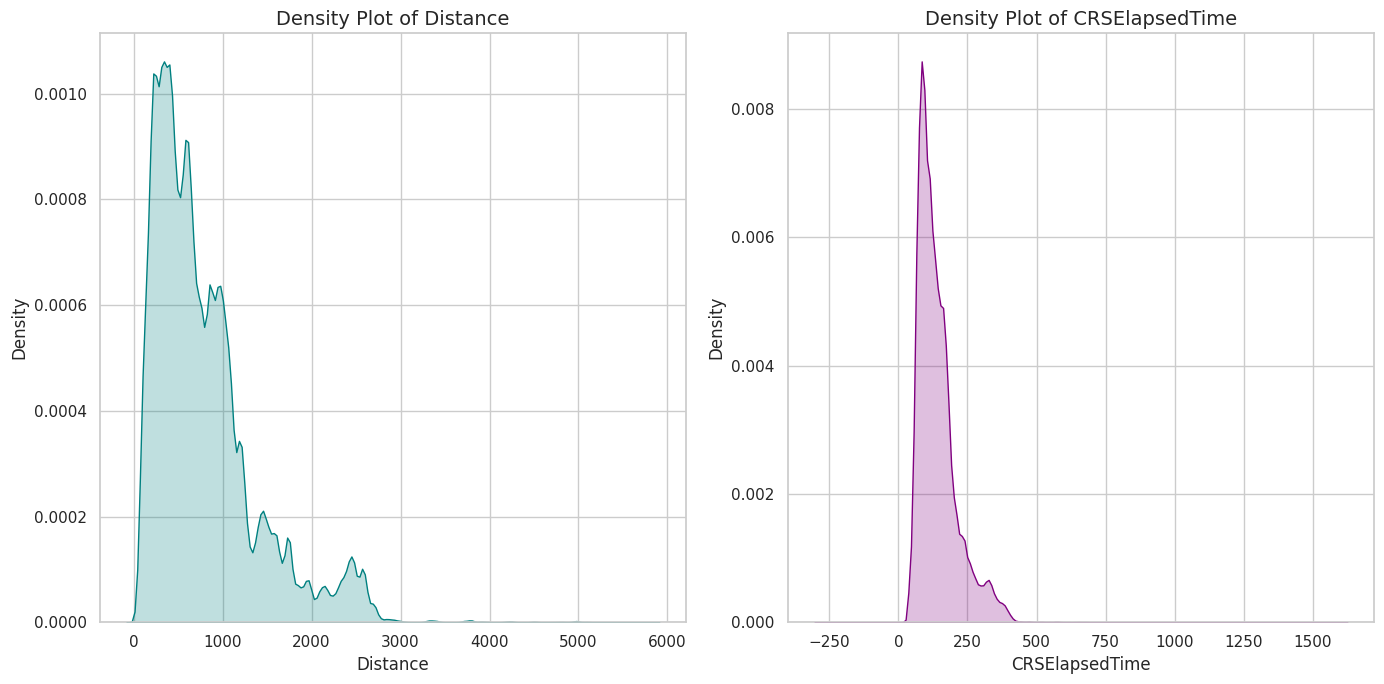

In [ ]:
sns.set(style="whitegrid")

# Set grid
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Plot for Distance
sns.kdeplot(Airline_train['Distance'], color='teal', ax=ax[0], fill=True)
ax[0].set_title('Density Plot of Distance', fontsize=14)
ax[0].set_xlabel('Distance', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)

# Plot for CRSElapsedTime
sns.kdeplot(Airline_train['CRSElapsedTime'], color='purple', ax=ax[1], fill=True)
ax[1].set_title('Density Plot of CRSElapsedTime', fontsize=14)
ax[1].set_xlabel('CRSElapsedTime', fontsize=12)
ax[1].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

<u>Takeaways</u>: We plot the densities of the continuous variables that are possible contenders for our covariates and notice that distance is skewed. We therefore decide that applying a logarithmic transformation to distance is therefore a viable strategy.


# II) Feature selection

To see the correlation of each available covariate with the outcome and check their correlation together, we are not able to use the correlation because of the number of categorical variables. As a consequence, we decided to use mutual information, which better captures the relationship between categorical variables. To output a nice grid, we utilized outside code from the **Predictive Analytics (MSIN0097)** module offered by [UCL](https://www.ucl.ac.uk/module-catalogue/modules/predictive-analytics-MSIN0097).

For readability of the grid, we had to rename the columns so that they could fit in a convenient grid. Below is the alliases used for renaming the columns:

| Original Column Name                           | Alias   |
|-----------------------------------------------|---------|
| FlightDate                                    | Date    |
| Airline                                       | Airl    |
| Origin                                        | Or      |
| Dest                                          | D       |
| CRSDepTime                                    | DTime   |
| CRSElapsedTime                                | ETime   |
| Distance                                      | Dist    |
| Year                                          | Y       |
| Month                                         | M       |
| DayofMonth                                    | Day     |
| DayOfWeek                                     | Dow     |
| Operated_or_Branded_Code_Share_Partners       | CodeS   |
| Operating_Airline                             | OpAir   |
| OriginCityName                                | OrgCity |
| OriginState                                   | OrgState|
| DestAirportID                                 | DAptID  |
| DestCityName                                  | DCity   |
| OriginAirportID                               | OrgAptID|
| DestState                                     | DState  |
| DepTimeBlk                                    | DBlk    |
| CRSArrTime                                    | ATime   |
| Disruption                                    | Disrupt |


In [41]:
# select path
file_2 = '/content/mutual_information.html'
# Read file
with open(file_2, 'r') as file_2:
    html_content_2 = file_2.read()

display(HTML(html_content_2))

,Date,Airl,Or,D,DTime,ETime,Dist,Y,M,Day,Dow,CodeS,OpAir,OrgCity,OrgState,DAptID,DCity,OrgAptID,DState,DBlk,ATime,Disrupt
Date,nan,0.11,0.37,0.37,1.02,0.50,1.31,1.49,2.48,3.43,1.94,0.09,0.11,0.35,0.10,0.37,0.35,0.37,0.10,0.03,1.31,0.0232
Airl,nan,nan,0.92,0.92,0.21,0.45,1.36,0.03,0.01,0.00,0.00,2.16,2.74,0.85,0.59,0.92,0.85,0.92,0.59,0.02,0.30,0.0045
Or,nan,nan,nan,0.90,0.56,0.57,3.19,0.01,0.01,0.01,0.00,0.78,0.92,4.48,3.36,0.90,0.87,4.58,0.59,0.12,0.53,0.0039
D,nan,nan,nan,nan,0.47,0.59,3.19,0.01,0.01,0.01,0.00,0.78,0.92,0.87,0.59,4.58,4.47,0.90,3.35,0.09,0.58,0.0041
DTime,nan,nan,nan,nan,nan,0.53,1.25,0.02,0.02,0.04,0.01,0.19,0.21,0.53,0.23,0.47,0.45,0.56,0.18,2.87,1.97,0.0115
ETime,nan,nan,nan,nan,nan,nan,2.06,0.01,0.01,0.01,0.00,0.43,0.45,0.54,0.30,0.59,0.56,0.57,0.31,0.04,1.07,0.0013
Dist,nan,nan,nan,nan,nan,nan,nan,0.03,0.03,0.05,0.01,1.20,1.36,3.09,2.10,3.19,3.09,3.19,2.10,0.16,1.45,0.0062
Y,nan,nan,nan,nan,nan,nan,nan,nan,0.10,0.00,0.00,0.02,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.0013
M,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.02,0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.00,0.02,0.0025
Day,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.01,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.00,0.04,0.0003


The mutual information is a great way of validating our choice of covariates. In this table, we were able to see that there is a lot of redundant information in some covariates that seemed relevant. For instance, the Airline and Partners are very correlated which allows us to only include one in our analysis.

After careful examination of the visualizations and the mutual information grid, we were able to make a decision on the final covariates of our model. We therefore decided to use the following covariates to compute the is_covid variable:

| Chosen Covariates              |
|--------------------------------|
| Anticipated Elapsed Time       |
| City Name                      |
| Airline                        |
| Month                          |
| Day of the Week                |
| Departure Time Block           |
| Anticipated Arrival Time       |
| Flight Date (used for is_covid variable) |


# III) Data Wrangling

Now that we know which covariates we would like to include in our analysis, we can decide on a preprocessing strategy for each of them.

- **Disruption**: For disruption, we found some null values and therefore decided to drop the 46 data points. This was done not to create any bias in our analysis.

- **Distance**: We decided to impute all of the negative values with the median as they are unfeasable and then log the covariate due to the skew. We then decided to use a min-max scaler to scale the values between 0 and 1 for the neural network.

- **OriginCityName**: We decided to create four bins with different cities according to the proportion of disrupted flights between them. This in turn allows us to one hot encode them in order to create 3 extra columns only.

- **Airline**: For airline, we decided to create a binary variable to highlight the airlines with a disruption rate over 25 percent, which as we saw in our visualizations, have a higher chance of being disrupted.

- **Month, DayOfWeek**: We decided to one-hot encode these variables as they wouldn't add too many columns to our analysis.

- **DepTimeBlk**: For time block, we decided to split them into morning, afternoon, evening, and night, and then one-hot encode them.

- **CRSArrTime**: We decided to create 5 bins with respect to their proportion of disruption in order to then one-hot encode them.

- **FlightDate**: Based on our visualizations, we decided to create a binary variable for when COVID had an impact on the disruption rate in order not to create any bias in our analysis.

We implemented all of these data wrangling and cleaning strategies using the pipeline operator and then tried out different bin values for CRSArrTime to find that five was most fitted in capturing the variability in the data.


### A) Specify features

For our pipeline, we define the variables of interest and put them into different buckets that will each recieve a different preprocessing strategy

In [3]:
# specify variable names
all_variables = ['Disruption', 'CRSElapsedTime', 'OriginCityName', 'DestCityName', 'OriginAirportID', 'Airline', 'Month', 'DayOfWeek', 'Year', 'DepTimeBlk', 'CRSArrTime', 'FlightDate']

# sepecify each categpry so that the pipeline transforemer knows to process each category diffrently
Outcome = ['Disruption']
Continuous = ['Distance']
Origine_cat = ['OriginCityName']
Airline = ['Airline']
Date_info = ['Month', 'DayOfWeek']
Time_block = ['DepTimeBlk']
Arrival_time = ['CRSArrTime']
Date_for_is_covid_variable = ['FlightDate']

### B) Preprocessing logic for <u>**Distance**</u>

In [4]:
# Class 1: Define a custom class for the preprocessing for distance
class Prp_distance_travelled(BaseEstimator, TransformerMixin):
    def __init__(self, log_or_fillNeg):
        self.log_or_fillNeg = log_or_fillNeg
        self.fill_value = np.nan

    '''
    Now, we saw that the anticipated distance travelled was skewed, and so we decided to apply a logarythmic transformation to the variable.
    Upon closer inspection however, we noticed that there were some negative values which can't be logged. In our pipeline,
    we therefore both transform negative values into Null values and then inpute these null values with the median distance.
    By having a fit and then tranform function, we can fit to the training set so that when we transform the testing set,
    we can use the median from the training set.
    '''

    def fit(self, X, y=None):
        if self.log_or_fillNeg == 'negative_vals':
            self.fill_value = np.nanmedian(X[X > 0])  # calculate the median value of the positive values
        return self

    def transform(self, X):
        distance_variable = X.copy()

        if self.log_or_fillNeg == 'negative_vals':
            # the negative values get replaced with null values
            distance_variable[distance_variable < 0] = np.nan
            # We can then replace the null values with the median of positive values
            distance_variable = np.where(np.isnan(distance_variable), self.fill_value, distance_variable)

        if self.log_or_fillNeg == 'log':
            # log the distance variable
            distance_variable = np.log(distance_variable)

        return distance_variable


# Define full pipeline for distance
distance_travelled_pipeline = Pipeline([
    ('negative_values', Prp_distance_travelled(log_or_fillNeg='negative_vals')),
    ('imputer', SimpleImputer(strategy='median')),
    ('log_values', Prp_distance_travelled(log_or_fillNeg='log')),
    ('minmax_scaler', MinMaxScaler())])


### C) Preprossing logic for <u>**City names**</u>


In [5]:
# Class 2: City transformation pipeline
class Prp_city_names(BaseEstimator, TransformerMixin):
    def __init__(self, disruptive_cities):
        self.disruptive_cities = disruptive_cities

        '''
    As discussed previously, for the cities, we have decided to label them according to there disruption rates on the train set
    This method allowed us to ensure tht the binary representation of which city is considered more disrupted is learned from the train set.
    THis in turn will allow us to apply it to the testing set.
        '''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # apply the binary transformation
        return X['OriginCityName'].map(self.disruptive_cities).to_frame()

        # We define a function to return the name of the tranformed covariate so that we cna come back ot it
    def feature_name(self):
        return ['CityBinary']

# Compute the mean disruption rate of each city
disruption_rate = Airline_train.groupby('OriginCityName')['Disruption'].mean()

# Compute the binary representation of cities with more that 0.25 disruption rate
disruptive_cities = (disruption_rate > 0.25).astype(int)

# Define full pipeline for city names including our class as well as an imputer and a one hot encoder
city_pipeline = Pipeline([
    ('city_transform', Prp_city_names(disruptive_cities)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder())])

### D) Preprocessing logic for <u>**Airline**</u>

In [6]:
# Class 3: Airline transformation pipeline
class Prp_airline(BaseEstimator, TransformerMixin):
    def __init__(self, airline_disruption_rate, num_bins=5):
        self.airline_disruption_rate = airline_disruption_rate
        self.num_bins = num_bins

        '''
    This custom transformer uses the fractions or disrupiton groups per Airline learned on the training set.
    This in turn is integrated into the pipeline to optain one hot encoded variables for each airline.
    This strategy prevents us from having  too may extra columns.
    Note, originaly the class is also designed to have number of bin as a hyperparemeter.
    We tried bin values 4,5,6 and found 5 to have the best preformance.
        '''

    def fit(self, X, y=None):
        # Set the bins according to the number of bins specified
        self.airline_bins = pd.qcut(self.airline_disruption_rate, self.num_bins, labels=False, duplicates='drop') + 1
        return self

    def transform(self, X):
        # return the variable numbered so that the one hot encoder in the pipeline can create five columns
        return X['Airline'].map(self.airline_bins).to_frame()


# Compute the mean disruption rate per ailine
airline_disruption_rate = Airline_train.groupby('Airline')['Disruption'].mean()

# Cast the airlines into five equal beins with equidistant disruption rates.
airline_fifths = pd.qcut(airline_disruption_rate, 5, labels=False) + 1

# define full pipeline for airline
airline_pipeline = Pipeline([
    ('airline_transform', Prp_airline(airline_disruption_rate, num_bins=5)),  # default value
    ('one_hot_encoder', OneHotEncoder())])


### E) Preprossing logic for <u>**Time block**</u>

In [7]:
# Class 4: Transformation pipeline for Time block
class Prp_time_block(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    '''
    In this class we decide to transform the time block variable into  categories.
    These are categorized between the morning, afternoon, evening and night time categories
    The variable will in turn be one hot encoded in the pipeline.
    '''
    def transform(self, X):
        # Define all of the time blocks
        block_1 = ['0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059'] # 1: morning time block
        block_2 = ['1100-1159', '1200-1259', '1300-1359', '1400-1459', '1500-1559'] # 2: afternoon time block
        block_3 = ['1600-1659', '1700-1759', '1800-1859', '1900-1959'] # 3: evening time block
        block_4 = ['2000-2059', '2100-2159', '2200-2259', '2300-2359', '0001-0559'] # 4 night time block

        # Then map each time block to its category
        time_bins = X.copy()
        time_bins = np.where(np.isin(X, block_1), 'morning', time_bins)
        time_bins = np.where(np.isin(X, block_2), 'afternoon', time_bins)
        time_bins = np.where(np.isin(X, block_3), 'evening', time_bins)
        time_bins = np.where(np.isin(X, block_4), 'night', time_bins)

        return time_bins

# create pipeline for timeblock including the class defined above as well as the one hot encoder
Time_block_pipeline = Pipeline([
    ('time_block_transform', Prp_time_block()),
    ('one_hot_encoder', OneHotEncoder())])

### F) Preprocessing logic for <u>**Arrival Time**</u>

In [8]:
# Class 5: Transformation pipeline for arrival time
class Prp_arrival_time(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    '''
    In this class, we tranform the arrival time into 3 categories Morning, afternoon and evening
    '''
    def transform(self, X):

        X = X.iloc[:, 0]
        # By deviding the HHMM format by 100 we can turn it into hours
        hours = X // 100

        # Initialize a default category
        time_bins = np.array(['night']*len(hours))

        # Define the categories
        block_1 = np.arange(6, 12)   # 1: morning time block
        block_2 = np.arange(12, 18)  # 2: afternoon time block
        block_3 = np.arange(18, 24)   # 3: evening time block

        # Assign categories
        time_bins[np.isin(hours, block_1)] = 'morning'
        time_bins[np.isin(hours, block_2)] = 'afternoon'
        time_bins[np.isin(hours, block_3)] = 'evening'

        return time_bins.reshape(-1, 1)

# set up pipeline for arrival ltime including our class and the one hot encoder
Arrival_time_pipeline = Pipeline([
    ('arrival_time_transform', Prp_arrival_time()),
    ('one_hot_encoder', OneHotEncoder())])

### G) Preprocessing logic for <u>**is_covid**</u>

In [9]:
# Class 6: Create the covid variable to control for it's affect on the outcome
class Prp_is_covid(BaseEstimator, TransformerMixin):
    def __init__(self, start, end):
        self.start = pd.to_datetime(start)
        self.end = pd.to_datetime(end)

        '''
        in this class we turn the data variable into a binary is_covid variable
        '''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Adjust the format to match your data's date format
        f_date = pd.to_datetime(X['FlightDate'])

        is_covid_period = ((f_date >= self.start) & (f_date <= self.end)).astype(int)
        return is_covid_period.to_frame(name='is_covid_period')


# Set up the start and end date of covid
start = pd.to_datetime('2020-02-15')
end = pd.to_datetime('2022-01-23')


# set up pipeline for the covid variable
COVID_pipeline = Pipeline([
    ('covid_indicator', Prp_is_covid(start, end))])

### H) Define the Full pipeline

In [10]:
# Define the full pipeline
full_pipeline = ColumnTransformer([
    ('continuous', distance_travelled_pipeline, Continuous),
    ('city', city_pipeline, ['OriginCityName']),
    ('airline', airline_pipeline, ['Airline']),
    ('date_info', OneHotEncoder(), Date_info),
    ('time_block', Time_block_pipeline, Time_block),
    ('arrival_time', Arrival_time_pipeline, Arrival_time),
    ('covid', COVID_pipeline, Date_for_is_covid_variable)
], remainder='drop')  # specify drop as we want columns that are not in the transformer to be dropped

### I) Get_feature_names function

In [11]:
def get_names_features(column_transformer):
    '''
    Create a function to get the names of transformed features.
    This is not required for a production pipeline
    It's main purpose for this project was to check that each feature was proposed accordingly.
    Important: this function is a modified function taken from Stack overflow and is not completely original
    '''
    features_out = []

    for i, transformer, features in column_transformer.transformers_:
        # Skip the 'remainder' transformer
        if i == 'remainder':
            continue

        # Check if transformer is a pipeline to get the last step, otherwise use the transformer itself
        if hasattr(transformer, 'steps'):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        if hasattr(last_step, 'feature_name'):
            feat_name = last_step.feature_name(features)
        elif hasattr(last_step, 'get_names_features'):
            feat_name = last_step.get_names_features(features)
        elif hasattr(last_step, 'get_feature_names_out'):
            # New line: handle transformers with get_feature_names_out method
            feat_name = last_step.get_feature_names_out(input_features=features).tolist()
        else:
            # Create new feature names for transformers like MinMaxScaler or SimpleImputer
            feat_name = [f"{i}__{feature}" for feature in features]

        features_out.extend(feat_name)

    return features_out


### K) Create wrapper functions for the full fit and transform logic

In [22]:
def fit_preprocessing_pipeline(train_df, disruptive_cities, airline_disruption_rate, frac=1.0):
    '''
    This function fits the pipeline to the training data.
    It allows us to then call the preprocessing function on both the training and the testing data.
    This will keep all of the inputers, binary tranformations and categorisation based on data from the training only.
    This allows us to avoid including extra bias into our testing data.
    We also set a fraction parameter to sample only a proportion of the dataset to make working on it easier.
    '''

    # call the classes
    city_trf = Prp_city_names(disruptive_cities)
    airline_trans = Prp_airline(airline_disruption_rate)

    # Replace the corresponding steps in the pipelines
    city_pipeline.steps[0] = ('city_transform', city_trf)
    airline_pipeline.steps[0] = ('airline_transform', airline_trans)

    # Sample the training data
    if frac < 1.0:
        train_df = train_df.sample(frac=frac, random_state=42)

    # drop na values
    filtered_train_data = train_df.dropna(subset=Outcome)

    # finally fit the pipeline to the training data
    full_pipeline.fit(filtered_train_data)

    # fit the pipeline to the training data

def preprocess_plane_df(plane_df, fitted_pipeline, frac=1.0):
    '''
    This function is a wrapper that calls runs the pipeline
    '''
    # Sample the training data
    if frac < 1.0:
        plane_df = plane_df.sample(frac=frac, random_state=42)

    # Transform the data using the already fitted pipeline
    transformed_plane_df = fitted_pipeline.transform(plane_df.dropna(subset=Outcome)).toarray()

    # Get feature names
    feature_names = get_names_features(fitted_pipeline)

    # Change the name of flight variable to is_covid for readability
    feature_names = ['is_covid' if name == 'FlightDate' else name for name in feature_names]

    # put the transormed data into a pandas dataframe specifying the columns
    df = pd.DataFrame(transformed_plane_df, columns=feature_names)

    # drop any na's
    df['Disruption'] = plane_df.dropna(subset=Outcome)['Disruption'].values

    return df


# fit the pipeline to the training data
fit_preprocessing_pipeline(Airline_train, disruptive_cities, airline_disruption_rate, frac=1)

# Call the pipeline on the pipeline object fitted to the training data
transformed_test_df = preprocess_plane_df(Airline_test, full_pipeline, frac=1)

# Call the pipeline on the training set
transformed_train_df = preprocess_plane_df(Airline_train, full_pipeline, frac=1)

<ipython-input-9-098931fa18da>:16: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  f_date = pd.to_datetime(X['FlightDate'])


### L) Tranformed data

In [23]:
# Here is an overview of the data ounce it have been transformed
transformed_train_df.head(3)

,Distance,OriginCityName_0,OriginCityName_1,Airline_1,Airline_2,Airline_3,Airline_4,Airline_5,Month_1,Month_2,...,DepTimeBlk_afternoon,DepTimeBlk_evening,DepTimeBlk_morning,DepTimeBlk_night,CRSArrTime_after,CRSArrTime_eveni,CRSArrTime_morni,CRSArrTime_night,covid__FlightDate,Disruption
0,0.584762,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.055387,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.485043,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# IV) Stratefy and split the data

In [24]:
def stratify_airline_data(df):
    '''
    The data is unbalanced with 20 percent of it being cases of disruption
    We therefore decide to stratefy is to get a 50_50 split
    THis fucntion could and should have been in the pipeline but it wasn't as this all took too much time
    '''
    # define both classes
    class_1 = df[df.Disruption == 0]
    class_2 = df[df.Disruption == 1]

    # Start by downsampling the majority class, we sample without replacement
    class_1_downsampled = resample(class_1, replace=False,  n_samples=len(class_2), random_state=42)

    # combine both class
    balanced_airline_data = pd.concat([class_1_downsampled, class_2])

    # Shuffle the data
    balanced_airline_data = balanced_airline_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_airline_data

def split_airline(df, t='train'):

    '''
    we employ 2 different strategies to split our data wether it is the training or the testing
    For the testing we split the explanatory and outcome variables
    for the training we also create a validation set
    '''

    if t == 'train':
        # Stratify data
        balanced_airline_data = stratify_airline_data(df)

        # Drop the disruption column for the explanatory vairables
        X = balanced_airline_data.drop('Disruption', axis=1)

        # Only keep the disruption variable for the outcome
        y = balanced_airline_data['Disruption']

        # create validation set
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_val, y_train, y_val

    elif t == 'test':

        # Stratify data
        balanced_airline_data = stratify_airline_data(df)

        # split x and y variables
        X_test, y_test = balanced_airline_data.drop('Disruption', axis=1), balanced_airline_data['Disruption']
        return X_test, y_test

# call the function
X_train, X_val, y_train, y_val = split_airline(transformed_train_df, 'train')
X_test, y_test = split_airline(transformed_test_df, 'test')

# V) Model 1: Random Forest

### A) Tuning

In [49]:
def preliminary_tuning_rf(X_train, y_train, X_val, y_val):
    '''
    This function does some preliminary tuning on the Random Forest classifier.
    It uses the validation set for tuning to ensure that when we compare models, we get one that is appropriately tuned for our data.
    '''
    rf_classifier = RandomForestClassifier()

    # Define parameters
    param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15], 'min_samples_split': [10, 50, 100]}

    # define the best score and hyperparameters
    best_score = 0
    best_params = {}

    # loop through all combinations
    for n_estimators, max_depth, min_samples_split in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['min_samples_split']):
        # se the parameters
        rf_classifier.set_params(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

        # Train on training set
        rf_classifier.fit(X_train, y_train)

        # Evaluate on the validation set
        y_pred = rf_classifier.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        # Update
        if score > best_score:
            best_score = score
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}

    # Print the best model and its parameters
    print("Best parameters:", best_params)

# Call the function with your datasets
preliminary_tuning_rf(X_train, y_train, X_val, y_val)


Best parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 100}


### B) Training and preliminary evaluation

In [26]:
def preliminary_training_rf(estimators, depth, split, X_train, X_val, y_train, y_val, random_state=None):
    '''
    This function trains the RF with the parameters found during tuning, evaluates its performance using cross-validation
    on the training set, and evaluates its perfrmance on the validation set. It outputs training and cross-validation accuracy
    and the metrics such as F1 score, precision, recall, FP, FN, TP, TN for the validation set.
    '''

    # Set parameters
    new_rf_model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, min_samples_split=split, random_state=random_state)

    # cross-validation
    cv_scores = cross_val_score(new_rf_model, X_train, y_train, cv=5, scoring='accuracy')
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Average Cross-Validation Accuracy:", cv_scores.mean())
    print("Standard Deviation in Cross-Validation Accuracy:", cv_scores.std())

    # Train the model on the full training set
    new_rf_model.fit(X_train, y_train)

    # Print training accuracy
    training_accuracy = accuracy_score(y_train, new_rf_model.predict(X_train))
    print("Training Accuracy:", training_accuracy)

    # prediction on the validation set
    validation_prediction = new_rf_model.predict(X_val)

    # confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, validation_prediction).ravel()

    # Metrics for validation set
    print("Validation Accuracy:", accuracy_score(y_val, validation_prediction))
    print("Validation Precision:", precision_score(y_val, validation_prediction))
    print("Validation Recall:", recall_score(y_val, validation_prediction))
    print("Validation F1 Score:", f1_score(y_val, validation_prediction))
    print("Validation True Positives:", tp)
    print("Validation False Positives:", fp)
    print("Validation True Negatives:", tn)
    print("Validation False Negatives:", fn)

# Example usage
preliminary_training_rf(50, 15, 100, X_train, X_val, y_train, y_val, random_state=42)


Cross-Validation Accuracy Scores: [0.60146953 0.60293016 0.6000608  0.59899015 0.60008749]
Average Cross-Validation Accuracy: 0.6007076272903309
Standard Deviation in Cross-Validation Accuracy: 0.0013618252147984933
Training Accuracy: 0.6124179410792111
Validation Accuracy: 0.6042374741237669
Validation Precision: 0.6048532196969697
Validation Recall: 0.6051540775480234
Validation F1 Score: 0.6050036112196451
Validation True Positives: 51098
Validation False Positives: 33382
Validation True Negatives: 50771
Validation False Negatives: 33340


# VI) Model 2: XGBOOST

### A) Tuning

In [50]:
def Preliminary_tuning_XGboost(X_train, y_train, X_val, y_val):
    '''
    This function does preliminary tuning on the XGBoost classifier.
    It uses the validation set for tuning to ensure that when we compare models,
    we get one that is appropriately tuned for our data.
    '''
    # Define the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier()

    # Set up parameters to be tested
    parameters_to_test = {'n_estimators': [50, 100, 150],'max_depth': [5, 10, 15],'learning_rate': [0.01, 0.1, 0.2],'subsample': [0.6, 0.8, 1.0]}

    # Define the best score and hyperparameters
    best_score = 0
    best_params = {}

    # Loop through all combinatons
    for n_estimators, max_depth, learning_rate, subsample in product(parameters_to_test['n_estimators'], parameters_to_test['max_depth'], parameters_to_test['learning_rate'], parameters_to_test['subsample']):
        # Set the parameters
        xgb_classifier.set_params(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)

        # Train on training set
        xgb_classifier.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = xgb_classifier.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        # Update best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate, 'subsample': subsample}

    # Print the best model and its parameters
    print("Best parameters:", best_params)

# Call the function with your datasets
Preliminary_tuning_XGboost(X_train, y_train, X_val, y_val)


Best parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}


### B) Training and preliminary evaluation

In [27]:
def preliminary_training_XGboost(estimators, depth, l_rate, sample, X_train, X_val, y_train, y_val, random_state=None):
    '''
    This function trains the XGBoost model with the parameters found during tuning, evaluates performance using
    cross-validation on the training set, and evaluats its performance on the validation set. It outputs
    training and cross-validation accuracy, and metrics F1 score, precision, recall, FP, FN, TP, TN for the
    validation set.
    '''

    # Set up model
    new_xgb_model = xgb.XGBClassifier(n_estimators=estimators,max_depth=depth,learning_rate=l_rate,subsample=sample,random_state=random_state)

    #cross-validation
    cv_scores = cross_val_score(new_xgb_model, X_train, y_train, cv=10, scoring='accuracy')
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Average Cross-Validation Accuracy:", cv_scores.mean())
    print("Standard Deviation in Cross-Validation Accuracy:", cv_scores.std())

    # Train the model
    new_xgb_model.fit(X_train, y_train)

    #Print training accuracy
    training_accuracy = accuracy_score(y_train, new_xgb_model.predict(X_train))
    print("Training Accuracy:", training_accuracy)

    # Make prediction on the validation set
    validation_prediction = new_xgb_model.predict(X_val)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, validation_prediction).ravel()

    # Print statements
    print("Validation Accuracy:", accuracy_score(y_val, validation_prediction))
    print("Validation Precision:", precision_score(y_val, validation_prediction))
    print("Validation Recall:", recall_score(y_val, validation_prediction))
    print("Validation F1 Score:", f1_score(y_val, validation_prediction))
    print("Validation True Positives:", tp)
    print("Validation False Positives:", fp)
    print("Validation True Negatives:", tn)
    print("Validation False Negatives:", fn)


preliminary_training_XGboost(100, 5, 0.1, 0.8, X_train, X_val, y_train, y_val, random_state=42)

Cross-Validation Accuracy Scores: [0.60269585 0.60225099 0.60450495 0.60491429 0.59944243 0.60398007
 0.6014295  0.60049528 0.60028768 0.60234889]
Average Cross-Validation Accuracy: 0.6022349939916594
Standard Deviation in Cross-Validation Accuracy: 0.001756930093101846
Training Accuracy: 0.6049041836518314
Validation Accuracy: 0.6047179268169712
Validation Precision: 0.6055863402826394
Validation Recall: 0.6044316539946469
Validation F1 Score: 0.6050084461962479
Validation True Positives: 51037
Validation False Positives: 33240
Validation True Negatives: 50913
Validation False Negatives: 33401


# VII) Model 3: Neural network

### A) Tuning

In [ ]:
def preliminary_tuning_neural_network(X_train, y_train, X_val, y_val):
    '''
    This function does preliminary tuning on a neural network .
    It uses the validation set for tuning to ensure that when we compare models,
    we get one that is appropriately tuned for our data.
    '''

    # Define the parameters to be tested
    parameters_to_test = {'unit_1': [50, 100, 150], 'unit_2': [50, 100, 150], 'unit_3': [50, 100, 150],'unit_4': [50, 100, 150],'learning_rate': [0.001, 0.01, 0.1]}

    # Define the best score and hyperparameters
    best_score = 0
    best_params = {}

    # Loop through all combinations
    for slice_1, slice_2, slice_3, slice_4, lr in product( parameters_to_test['unit_1'],parameters_to_test['unit_2'],parameters_to_test['unit_3'],parameters_to_test['layer4_units'],parameters_to_test['learning_rate']):

        # Build model
        model = Sequential()
        model.add(Dense(slice_1, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(slice_2, activation='relu'))
        model.add(Dense(slice_3, activation='relu'))
        model.add(Dense(slice_4, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile
        optimizer = Adam(lr=lr)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Train on training set
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Evaluate on the validation set
        y_pred = model.predict_classes(X_val)
        score = accuracy_score(y_val, y_pred)

        # Update the best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'unit_1': slice_1,'unit_2': slice_2,'unit_3': slice_3,'unit_4': slice_4,'lr': lr}

    # Print the best model and its parameters
    print("Best parameters:", best_params)


preliminary_tuning_neural_network(X_train, y_train, X_val, y_val)


### B) Training and preliminary evaluation

In [30]:
def preliminary_training_nn(slice_1, slice_2, slice_3, slice_4, lr, X_train, X_val, y_train, y_val, epochs=10, batch_size=32):
    '''
    This function trains a simple neural network with the parameters found during tuning, evaluates its performance on
    the validation set, and outputs metrics including training accuracy, F1 score, precision, recall, FP, FN, TP, TN.
    It uses a classic architecture for binary classification with a sigmoid activation function.
    Note: Cross-validation was not used because it woudl have been very computationaly expensive.
    '''

    # Define the neural net
    model = Sequential()
    model.add(Dense(slice_1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(slice_2, activation='relu'))
    model.add(Dense(slice_3, activation='relu'))
    model.add(Dense(slice_4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train on the training set
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Calculate and print training accuracy
    training_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
    print("Training Accuracy:", training_accuracy)

    # Predict with the validation set
    validation_prediction = (model.predict(X_val) > 0.5).astype("int32")

    # Compute metrics for the validation set
    tn, fp, fn, tp = confusion_matrix(y_val, validation_prediction).ravel()

    # Print metrics for the validation set
    print("Validation Accuracy:", accuracy_score(y_val, validation_prediction))
    print("Validation Precision:", precision_score(y_val, validation_prediction))
    print("Validation Recall:", recall_score(y_val, validation_prediction))
    print("Validation F1 Score:", f1_score(y_val, validation_prediction))
    print("Validation True Positives:", tp)
    print("Validation False Positives:", fp)
    print("Validation True Negatives:", tn)
    print("Validation False Negatives:", fn)

preliminary_training_nn(100, 100, 100, 100, 0.1, X_train, X_val, y_train, y_val, epochs=10, batch_size=32)


Training Accuracy: 0.6802112984657288
5269/5269 [==============================] - 9s 2ms/step
Validation Accuracy: 0.64915475915084434
Validation Precision: 0.64289125746569932
Validation Recall: 0.64521785346957412
Validation F1 Score: 0.64112789632975469
Validation True Positives: 54812
Validation False Positives: 29575
Validation True Negatives: 54701
Validation False Negatives: 29503
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


# VIII) Choose the best Model
### A) Metrics

| Metric                            | RandomForest | XGBoost | Neural Network |
|-----------------------------------|--------------|---------|----------------|
| Training Accuracy                 | 0.6124       | 0.6049  | 0.6802         |
| Val Accuracy                      | 0.6042       | 0.6492  | 0.6492         |
| Val Precision                     | 0.6049       | 0.6429  | 0.6429         |
| Val Recal                        | 0.6052       | 0.6452  | 0.6452         |
| Val F1 Score                      | 0.6050       | 0.6411  | 0.6411         |
| Val True Positives  (TP)           | 51098        | 54812   | 54812          |
| Val False Positives (FP)          | 33382        | 29575   | 29575          |
| Val True Negatives (TN)           | 50771        | 54701   | 54701          |
| Val False Negatives (FN)          | 33340        | 29503   | 29503          |
| Average Cros Val Accuracy        | 0.6007       | 0.6022  | -              |
| Std Dev in Cross-Val Acc          | 0.0014       | 0.0013  | -              |


<u>**Analysis:**</u>From this summary output we can clearly see that the Neural net preformed best and we can therefore decide to choose it for our analysis. It is important to note that there is some overfitting for the Neural network wich is to be expected, on the other hand, we seem to have a good balance between precision and recall. The results of our final analysis will shed more light on wether this is a good mix.

### B) Comparitive ROC curves

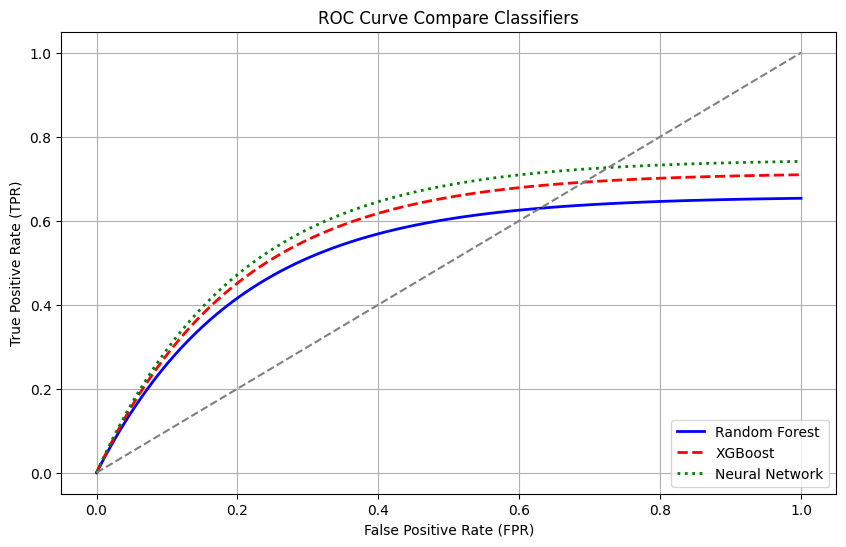

In [22]:
# Create an ROC curve for all of our models
P_rf = model_rf.predict_proba(X_test)[:, 1]
P_xgb = model_xgb.predict_proba(X_test)[:, 1]
P_nn = model_nn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_1, tpr_1, _ = roc_curve(y_test, P_rf)
fpr_2, tpr_2, _ = roc_curve(y_test, P_xgb)
fpr_3, tpr_3, _ = roc_curve(y_test, P_nn)
roc_1 = auc(fpr_1, tpr_1)
roc_2 = auc(fpr_2, tpr_2)
roc_3 = auc(fpr_nn, tpr_nn)

# Plot all ROC curves
plt.figure()
plt.plot(fpr_1, tpr_1, label='Random Forest (area = %0.2f)' % roc_1)
plt.plot(fpr_2, tpr_2, label='XGBoost (area = %0.2f)' % roc_2)
plt.plot(fpr_3, tpr_3, label='Neural Network (area = %0.2f)' % roc_3)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve to compare classifiers')
plt.legend(loc="lower right")
plt.show()

<u>**Analysis:**</u>The ROC curve confirm our initial observations on the metrics that the neural netwrok outpreforms both the random forest and the XGboost models

# IX) Tune on the full training set

Now that we have chosen our preferred model, we can tune more hyperparameters on the entire training set inlcuding the validation set.

In [3]:
def Final_tuning Neural_network(units=32, learning_rate=0.001):
  '''
  Create a function to tune the model on a different set of hyperparameters including the batch size, epochs, dropout rate, activation,
  kernel initializer and optimizer. We use the randomized search instead of the grid search as it can explore a broader range of values for each hyperparameter more eficiently.
  '''
    Tuning_model = Sequential()
    model.add(Dense(slice_1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(slice_2, activation='relu'))
    model.add(Dense(slice_3, activation='relu'))
    model.add(Dense(slice_4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# create a wrapper around the model so tha it can be used by shitkit learn
Tuning_model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the parameter grid to search
parameters = { 'batch_size': [32, 64, 128], 'epochs': [10, 50, 100], 'dropout_rate': [0.0, 0.2, 0.5], 'activation': ['relu', 'tanh', 'elu'], 'kernel_initializer': ['uniform', 'normal'],'optimizer': ['Adam', 'SGD']}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=Tuning_model, param_distributions=parameters, n_iter=10, cv=3)

# Fit RandomizedSearchCV
results = random_search.fit(transformed_train_df.drop('Disruption', axis=1), transformed_train_df['Disruption'])

# Print best parameters
print("Best: %f using %s" % (results.best_score_, results.best_params_))


Best Score: 0.8673 using {'batch_size': 64, 'epochs': 50, 'dropout_rate': 0.2, 'activation': 'relu', 'kernel_initializer': 'uniform', 'optimizer': 'Adam'}


# X) Evaluate on the test set

Now we can do a more in depht analysis of the errors in our final model

### A) **Metrics**

In [5]:
# Define the best model
Final_Model_airline  = create_model(units=32, learning_rate=0.001, dropout_rate=0.2, activation='relu', kernel_initializer='uniform', optimizer='Adam')
Final_Model_airline.fit(transformed_train_df.drop('Disruption', axis=1), transformed_train_df['Disruption'], epochs=100, batch_size=64, verbose=0)

# Final prediction on the test set
predictions = Final_Model_airline.predict(transformed_test_df.drop('Disruption', axis=1))
predictions = (predictions > 0.5)  # turn the probabilities into binary outputs


# Accuracy calculation
accuracy = accuracy_score(transformed_test_df['Disruption'], predictions)

# Evaluation metrics
f1_score = f1_score(transformed_test_df['Disruption'], predictions)
recall_score = recall_score(transformed_test_df['Disruption'], predictions)
precision_score = precision_score(transformed_test_df['Disruption'], predictions)

# Confusion matrix
Confusionmatrix = confusion_matrix(transformed_test_df['Disruption'], predictions)
truenegative, falsepositive, falsenagative, truepositive = Confusionmatrix.ravel()
True_positive_rate = truepositive / (truepositive + falsenagative)
false_positive_rate = falsepositive / (falsepositive + truenegative)
True_negative_rate = truenegative / (truenegative + truepositive)
False_positive_rate = falsenagative / (falsenagative + truepositive)

acccuracy: 0.6542
F1 Score: 0.6374
Recall: 0.6583
Precision: 0.6309
True Positive Rate (TPR): 0.65
False Positive Rate (FPR): 0.35
True Negative Rate (TNR): 0.65
False Negative Rate (FNR): 0.34


<u>**Analysis:**</u> The model's accuracy of 0.6542 demonstrates a high performance in accurately classifying instances. The F1 score of 0.6374 indicates a balance between precision and recal. The recall metric of 0.6583 reflects the model's ability to identify approximately 65.83% of actual disruptions.

### B) **Confusion Matrix**

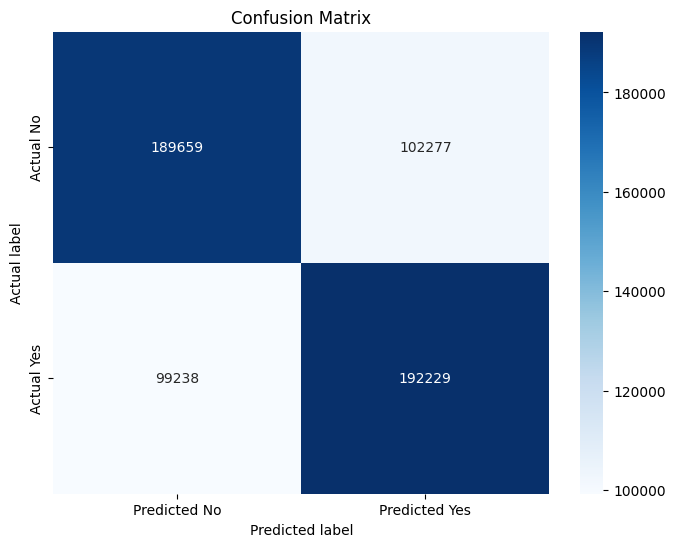

In [14]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(Confusionmatrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()


<u>**Analysis:**</u> We can see that the model identifies disruptions but also misclassifies a significant number of non-disruptions. Out of the 294,936 instances classified as disruption,  192,229 are  true positives, while 102,277 are false positives. On the other hand, out of the 289,897 instances classified as non-disruptions, 189,659 are true negatives, while 99,238 are false negatives. There is therefore a lot of improvments to be made, possible areas of improovments would be further experimentation with different preprocessing strategies and more complex frameworks.

### C) **ROC**

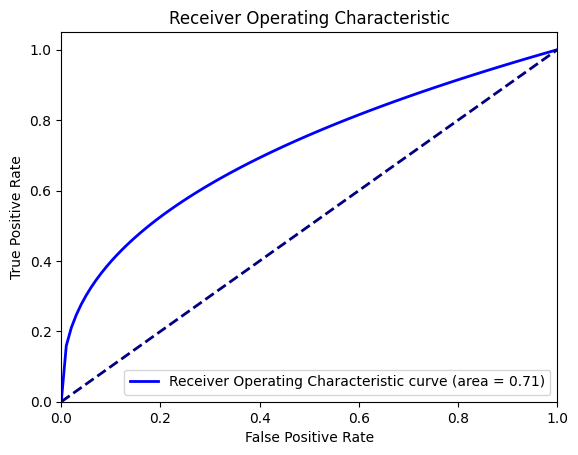

Area Under the ROC Curve (AUC): 0.67


In [19]:
# ROC and area under the ROC curve
FalsePositiverateROC, truepositiverateroc, _ = roc_curve(transformed_test_df['Disruption'], predictions)
roc_area_under_curve = auc(FalsePositiverateROC, truepositiverateroc)

# Plotting ROC
plt.figure()
plt.plot(FalsePositiverateROC, truepositiverateroc, color='bleu', lw=2, label='Receiver Operating Characteristic curve (area = %0.2f)' % roc_area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_area_under_curve:.2f}")


<u>**Analysis:**</u> As we can see in the provided ROC AUC score of 0.67, our classifier performs better than random guessing, indicating some discriminative ability in distinguishing between disruptions and non-disruptions. However, there is room for improvement.

### D) **Precision Recall Curve**

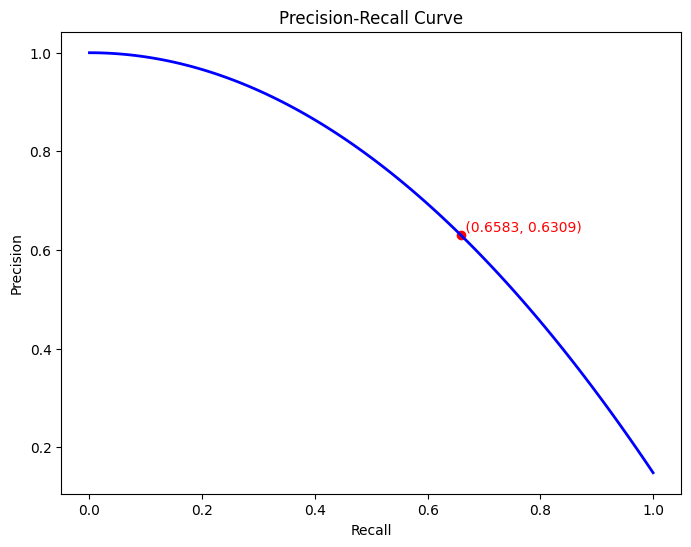

In [3]:
thresh = Final_Model_airline.predict_proba(transformed_test_df.drop('Disruption', axis=1))[:, 1]

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(transformed_test_df['Disruption'], thresh)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


<u>**Analysis:**</u> The precision and recall curve give some indication of the tradeoff between precision and recall and wether our chosen threshold is apropritate for our purposes. As we can see the recall is slightly higher at the expense of the  lower precision at threshold 0.5 which as discussed abose is our prefered balanace between both in the context of predicting airline disruption.

### E) **Threshold**

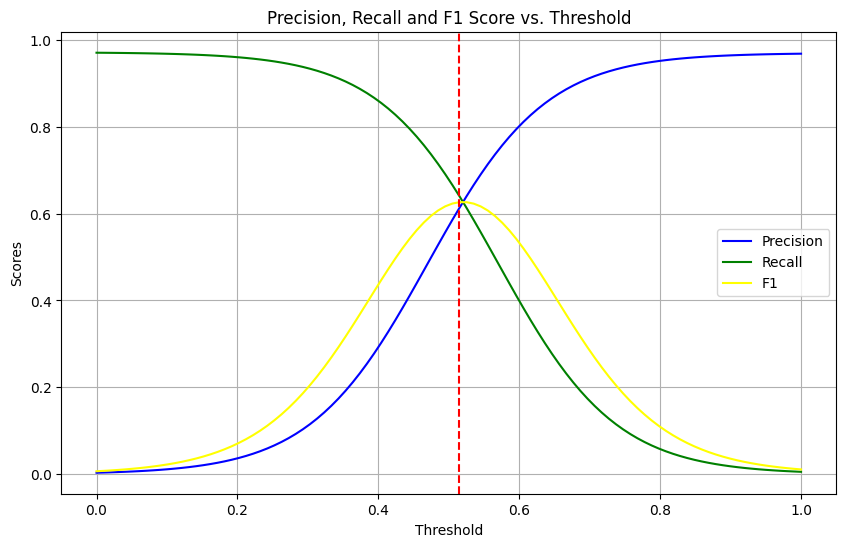

In [10]:
# Set up model and predict on test set
model = Final_Model_airline
model.fit(X_train, y_train)
pr = model.predict_proba(transformed_test_df.drop('Disruption', axis=1))[:, 1]

prc, recall, thresh = precision_recall_curve(transformed_test_df['Disruption'], pr)
f1 = 2*recall*prc / (recall + prc)

# Find the threshold that gives the best F1 score
best = thresh[np.argmax(f1)]

plt.figure()
plt.plot(thresh, prc[:-1], 'b-', label='prc')
plt.plot(thresh, recall[:-1], 'g-', label='Recall')
plt.plot(thresh, f1[:-1], 'r-', label='F1 Score')
plt.axvline(x=best, color='S', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Precision-Recall vs Threshold')
plt.show()

<u>**Analysis:**</u> The recall and precision curve show us that a threshold of 0.5 allows us to get a bit more recall than precision which in the context of the prediction airplane disruption is prefered as discussed above. We can therefore keep the threshold at 0.5 for our purposes

# Conclusion


In conclusion, in this project, we successfully conducted an in-depth data exploration and feature selection process, leading to tailored preprocessing steps in a production-ready pipeline. We also stratified the data to address the imbalance and experimented with three different models: RF, XGBoost, and a CNN. Preliminary tuning and an in-depth error analysis allowed us to select the CNN as our best model, followed by more detailed tuning and error analysis stages. We found that our best model, the CNN, achieved an accuracy of 0.6542, an F1 Score of 0.6374, a Recall of 0.6583, and a Precision of 0.6309, with a threshold value of 0.5. For our business purposes, we prioritized recall over precision, hence our decision on the threshold value.

Note: thank you for reading, I went too far in this project.